#### Importing Libraries

In [1]:
!pip install keras_facenet

In [2]:
import numpy as np
from random import choice
import matplotlib.pyplot as plt
from os import listdir
from os.path import isdir
from PIL import Image
#from inception_resnet_v1 import *
from keras_facenet import FaceNet
from mtcnn import MTCNN
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

#### Data Pre processing

In [3]:
def extract_face(filename, required_size = (160,160)):
    # Loading images
    image = Image.open(filename)
    # Converting it into RGB since the FaceNet model takes RGB images
    image = image.convert('RGB')
    # Converting the image to an array
    pixels = np.asarray(image)
    # Using the MTCNN detector with default weights
    detector = MTCNN()
    # Detecting the faces in the image
    result = detector.detect_faces(pixels)
    # Extracting the bounding box for the first detected face
    x1, y1, width, height = result[0]['box']
    # The values in result might be negative values.
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1+width, y1+height
    # Extracting the face
    face = pixels[y1:y2, x1:x2]
    # Resizing the face to model inputs
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [4]:
def load_faces(directory):
    faces = []
    # Enumerating the files
    for file in listdir(directory):
        path = directory + file
        # Getting the faces
        face = extract_face(path)
        # Appending the face into the faces list.
        faces.append(face)
    return faces

In [5]:
def load_dataset(directory):
    X, y = [], []
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # ignoring if there are any files directly in the directory
        if not isdir(path):
            continue
        # Loading all the faces
        faces = load_faces(path)
        # creating labels
        labels = [subdir for _ in range(len(faces))]
        # Summary
        print("Loaded faces = %d, %s", (len(faces), subdir))
        # Storing all the data
        X.extend(faces)
        print(type(X))
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [6]:
# Loading training set
X_train, y_train = load_dataset('5-celebrity-faces-dataset/train/')
print(X_train.shape)
print(y_train.shape)
# Loading testing set
X_test, y_test = load_dataset('5-celebrity-faces-dataset/val/')
print(X_test.shape)
print(y_test.shape)

Metal device set to: Apple M1 Pro
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 164ms/step
Loaded faces = %d, %s (14, 'ben_afflek')
<class 'list'>
3/3 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 238ms/step
Loaded faces = %d, %s (19, 'madonna')
<class 'list'>
2/2 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 342ms/step
Loaded faces = %d, %s (17, 'elton_john')
<class 'list'>
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 433ms/step
Loaded faces = %d, %s (22, 'mindy_kaling')
<class 'list'>
1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 467ms/step
Loaded faces = %d, %s (21, 'jerry_seinfeld')
<class 'list'>
(93, 160, 160, 3)
(93,)
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 437ms/step
Loaded faces = %d, %s (5, 'ben_afflek')
<class 'list'>
1/1 [==============================] - 1s 520ms/step
Loaded faces = %d, %s (5, 'madonna')
<class 'list'>
1/1 [==============================] - 0s 470ms/step
Loaded faces = %d, %s (5, 'elton_john')
<class 'list'>
1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 1s 502ms/step
Loaded faces = %d, %s (5, 'mindy_kaling')
<class 'list'>
1/1 [==============================] - 1s 564ms/step
Loaded faces = %d, %s (5, 'jerry_seinfeld')
<class 'list'>
(25, 160, 160, 3)
(25,)


#### Creating Face Embeddings

In [7]:
model = FaceNet()

In [8]:
def get_embeddings(model, face_pixels):
    # Scaling the pixel values
    face_pixels = face_pixels.astype('float32')
    # Standardizing the face pixel values
    #std, mean = face_pixels.std(), face_pixels.mean()
    #face_pixels = (face_pixels - mean)/std
    # Transforming each face into a single sample
    samples = np.expand_dims(face_pixels, axis = 0)
    # Making predictions to get face embeddings
    face_embeddings = model.embeddings(samples)
    return face_embeddings

In [9]:
# Getting the face embeddings for training samples
X_train_embed = []
for face_pixels in X_train:
    embeddings = get_embeddings(model, face_pixels)
    X_train_embed.append(embeddings[0])
X_train_embed = np.asarray(X_train_embed)
print(X_train_embed.shape)

1/1 [==============================] - 0s 32ms/step
(93, 512)


In [10]:
# Getting the face embeddings for training samples
X_test_embed = []
for face_pixels in X_test:
    embeddings  = get_embeddings(model, face_pixels)
    X_test_embed.append(embeddings[0])
X_test_embed = np.asarray(X_test_embed)
print(X_test_embed.shape)

1/1 [==============================] - 0s 33ms/step
(25, 512)


#### Face Classification

In [11]:
# Normalizing input vectors
in_encoder = Normalizer(norm='l2')
train_X = in_encoder.fit_transform(X_train_embed)
test_X = in_encoder.transform(X_test_embed)

In [12]:
# Label Encoding the targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)


In [13]:
# Fit the model
model = SVC(kernel='rbf', probability=True)
model.fit(train_X, y_train)

SVC(probability=True)

In [14]:
# Predict
yhat_train = model.predict(train_X)
yhat_test = model.predict(test_X)

In [15]:
# score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


#### Randomly selecting one samples and testing model's accuracy

In [16]:
# Randomly selecting a sample and checking if the model performs well 
selection = choice([i for i in range(test_X.shape[0])])
#selection = 10
rand_face_pixels = X_test[selection]
rand_face_emb = X_test_embed[selection]
rand_face_class = y_test[selection]
rand_face_name = out_encoder.inverse_transform([rand_face_class])

In [17]:
# Predictions for the face
sample = np.expand_dims(rand_face_emb, axis=0)
yhat_class = model.predict(sample)
yhat_prob = model.predict_proba(sample)

In [18]:
# Getting the name for the face
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % rand_face_name[0])

Predicted: madonna (81.288)
Expected: madonna


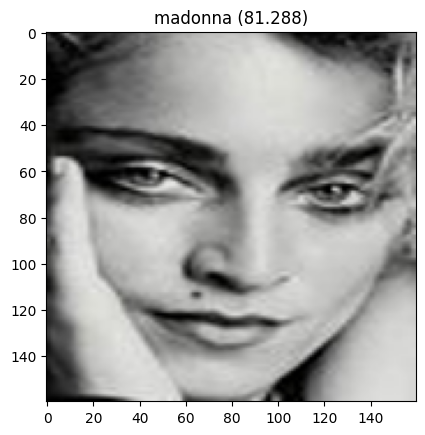

In [19]:
# Plotting the output
plt.imshow(rand_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()